In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from solve_yw import YullieWalker
from datetime import datetime
import scipy

In [2]:
data_path = "../../datasets/eyetracking/Eye-tracking-Kaggle"
fnames = glob.glob(data_path + "/*.csv")
print("found {} files".format(len(fnames)))

found 26 files


In [3]:
data = pd.read_csv(fnames[1], low_memory=False)
data.head(5)

,Unnamed: 0,RecordingTime [ms],Time of Day [h:m:s:ms],Trial,Stimulus,Export Start Trial Time [ms],Export End Trial Time [ms],Participant,Color,Tracking Ratio [%],...,Gaze Vector Left Y,Gaze Vector Left Z,Annotation Name,Annotation Description,Annotation Tags,Mouse Position X [px],Mouse Position Y [px],Scroll Direction X,Scroll Direction Y,Content
0,0,4677761.695,13:20:35:000,Trial001,01vnvg151201b1.avi,0.0,48822.134,50,Coral,76.8504,...,-,-,-,-,-,-,-,-,-,vnvg151201b1.avi
1,1,4677773.919,13:20:35:012,Trial001,01vnvg151201b1.avi,0.0,48822.134,50,Coral,76.8504,...,0.0000,0.0000,-,-,-,-,-,-,-,-
2,2,4677793.801,13:20:35:032,Trial001,01vnvg151201b1.avi,0.0,48822.134,50,Coral,76.8504,...,0.0000,0.0000,-,-,-,-,-,-,-,-
3,3,4677813.819,13:20:35:052,Trial001,01vnvg151201b1.avi,0.0,48822.134,50,Coral,76.8504,...,0.0000,0.0000,-,-,-,-,-,-,-,-
4,4,4677833.682,13:20:35:072,Trial001,01vnvg151201b1.avi,0.0,48822.134,50,Coral,76.8504,...,0.0000,0.0000,-,-,-,-,-,-,-,-


In [4]:
participants = data['Participant'].unique()
print(participants)

['50' '43' '48' '52' '49' '51' '55' '44' '45' '53' '47' '46' '42'
 'Unidentified(Neg)' '13' 'Unidentified(Pos)' '20' '19' '27' '17' '15'
 '21' '23' '28' '18' '14']


In [5]:
columns = data.columns
data = data.replace('-', np.nan)

In [6]:
columns2parse = ['Pupil Diameter Left [mm]', 'Pupil Diameter Right [mm]', 'Gaze Vector Right Y', 'Gaze Vector Right X',
     'Gaze Vector Left Y', 'Gaze Vector Left X']
for c in columns2parse:
    data[c] = pd.to_numeric(data[c].replace('-', np.nan))
data[data['Participant']=='43']['Pupil Diameter Left [mm]']

1917       NaN
1918    2.8974
1919    2.8823
1920    2.8757
1921    2.8342
         ...  
3653    2.7643
3654    2.8603
3655    2.8603
3656    2.8603
3657    2.8603
Name: Pupil Diameter Left [mm], Length: 1741, dtype: float64

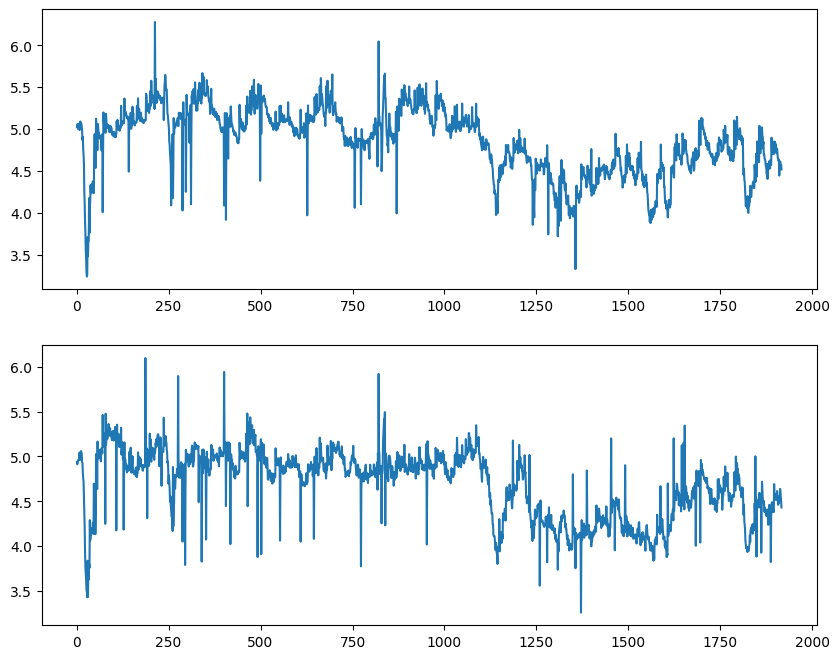

In [7]:
fig, ax = plt.subplots(2, figsize=(10, 8))
ax[0].plot(data[data['Participant']=='50']['Pupil Diameter Left [mm]'])
ax[1].plot(data[data['Participant']=='50']['Pupil Diameter Right [mm]'])
plt.show()

In [8]:
def time_to_seconds(time_str):
    # Convert time string to datetime object
    time_obj = datetime.strptime(time_str, "%H:%M:%S:%f")

    # Calculate total seconds
    total_seconds = (time_obj.hour * 3600 + time_obj.minute * 60 + time_obj.second +
                     time_obj.microsecond / 1e6)

    return total_seconds

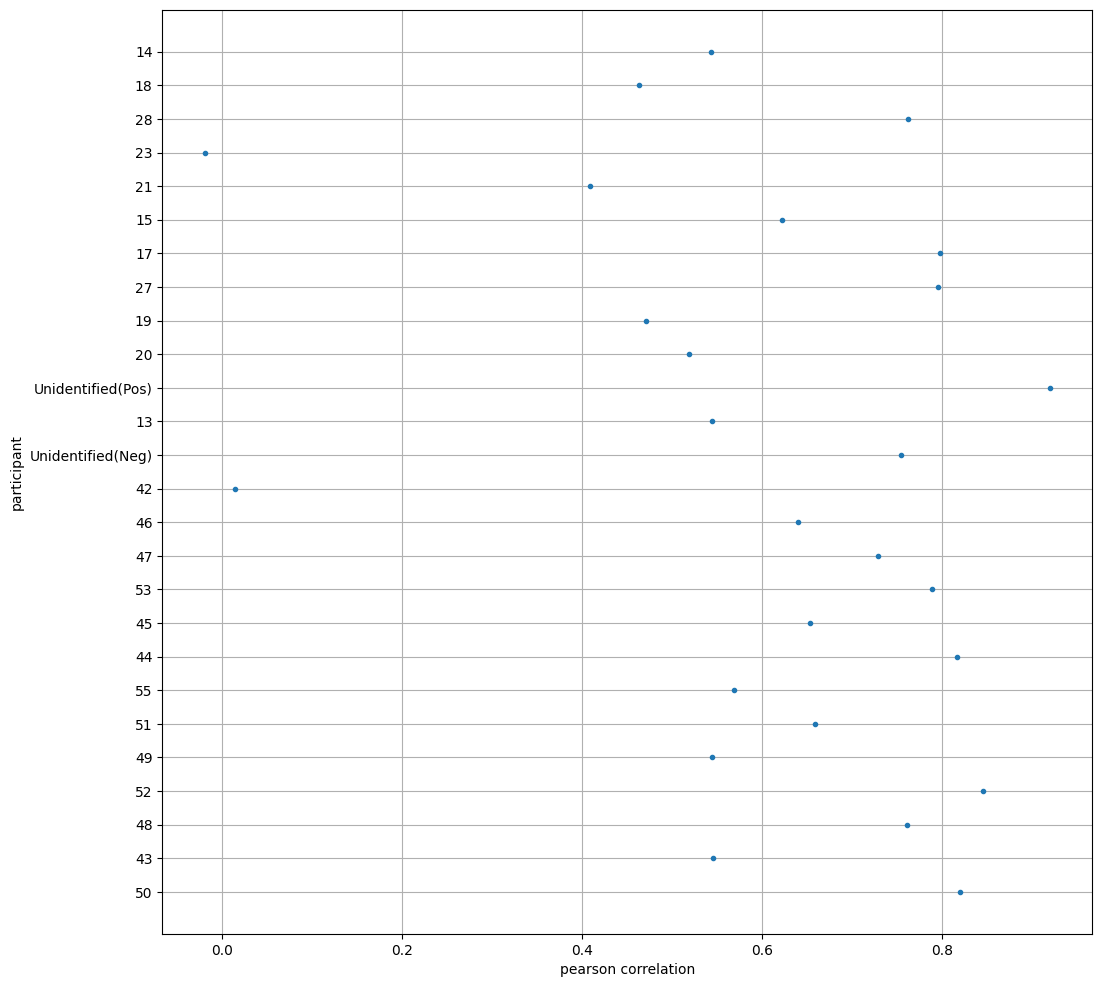

In [9]:
corrs = []
for p in participants:
    left = data[data['Participant']==p]['Pupil Diameter Left [mm]'].dropna().to_numpy()
    right = data[data['Participant']==p]['Pupil Diameter Right [mm]'].dropna().to_numpy()
    corrs.append(scipy.stats.pearsonr(left, right)[0])
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(corrs, participants, '.')
ax.set_xlabel("pearson correlation")
ax.set_ylabel("participant")
ax.grid(True)
plt.show()

In [10]:
left = data[data['Participant']=='47']['Pupil Diameter Left [mm]'].dropna().to_numpy()
right = data[data['Participant']=='47']['Pupil Diameter Right [mm]'].dropna().to_numpy()
t_ax = t = np.array([time_to_seconds(t) for t in data[data['Participant']=='47']["Time of Day [h:m:s:ms]"].dropna()])[1:]
t_ax = t_ax-t_ax[0]
t_ax = t_ax[:left.shape[-1]]

In [11]:
YW = YullieWalker()

In [12]:
left_est, theta_left = YW.est_ar_params(left, win_len=4, step=1)
right_est, theta_right = YW.est_ar_params(right, win_len=4, step=1)
print(t_ax.shape, left.shape, left_est.shape)
err_l = left-left_est
err_r = right-right_est
print(theta_left)
print(theta_right)
print(err_l.std(), theta_right.std())

(2289,) (2289,) (2289,)
[0.45001655 0.33142607 0.17239486 0.04602473]
[0.43944713 0.2678897  0.17345712 0.11907135]
0.06841412499934887 0.12166693789820111


/media/avi/54561652561635681/projects/eyetracking/solve_yw.py:42: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  theta = np.linalg.lstsq(A, b)[0]


In [43]:
blinks_l = (np.abs(left-left_est) > err_l.std() * 3) & (err_l < 0) & (left < left.mean())
blinks_r = (np.abs(right-right_est) > err_r.std() * 3) & (err_r < 0) & (right < right.mean())

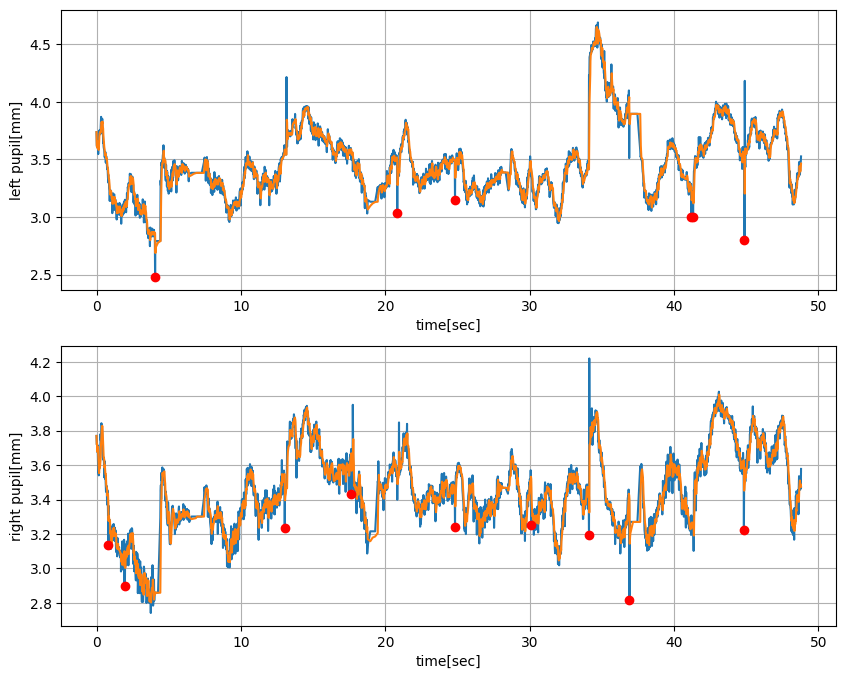

In [44]:
fig, ax = plt.subplots(2, figsize=(10, 8))
ax[0].plot(t_ax, left)
ax[0].plot(t_ax, left_est)
ax[0].plot(t_ax[blinks_l], left[blinks_l], 'ro')
ax[0].grid(True)
ax[0].set_ylabel("left pupil[mm]")
ax[0].set_xlabel("time[sec]")
ax[1].plot(t_ax, right)
ax[1].plot(t_ax, right_est)
ax[1].plot(t_ax[blinks_r], right[blinks_r], 'ro')
ax[1].grid(True)
ax[1].set_ylabel("right pupil[mm]")
ax[1].set_xlabel("time[sec]")
plt.show()

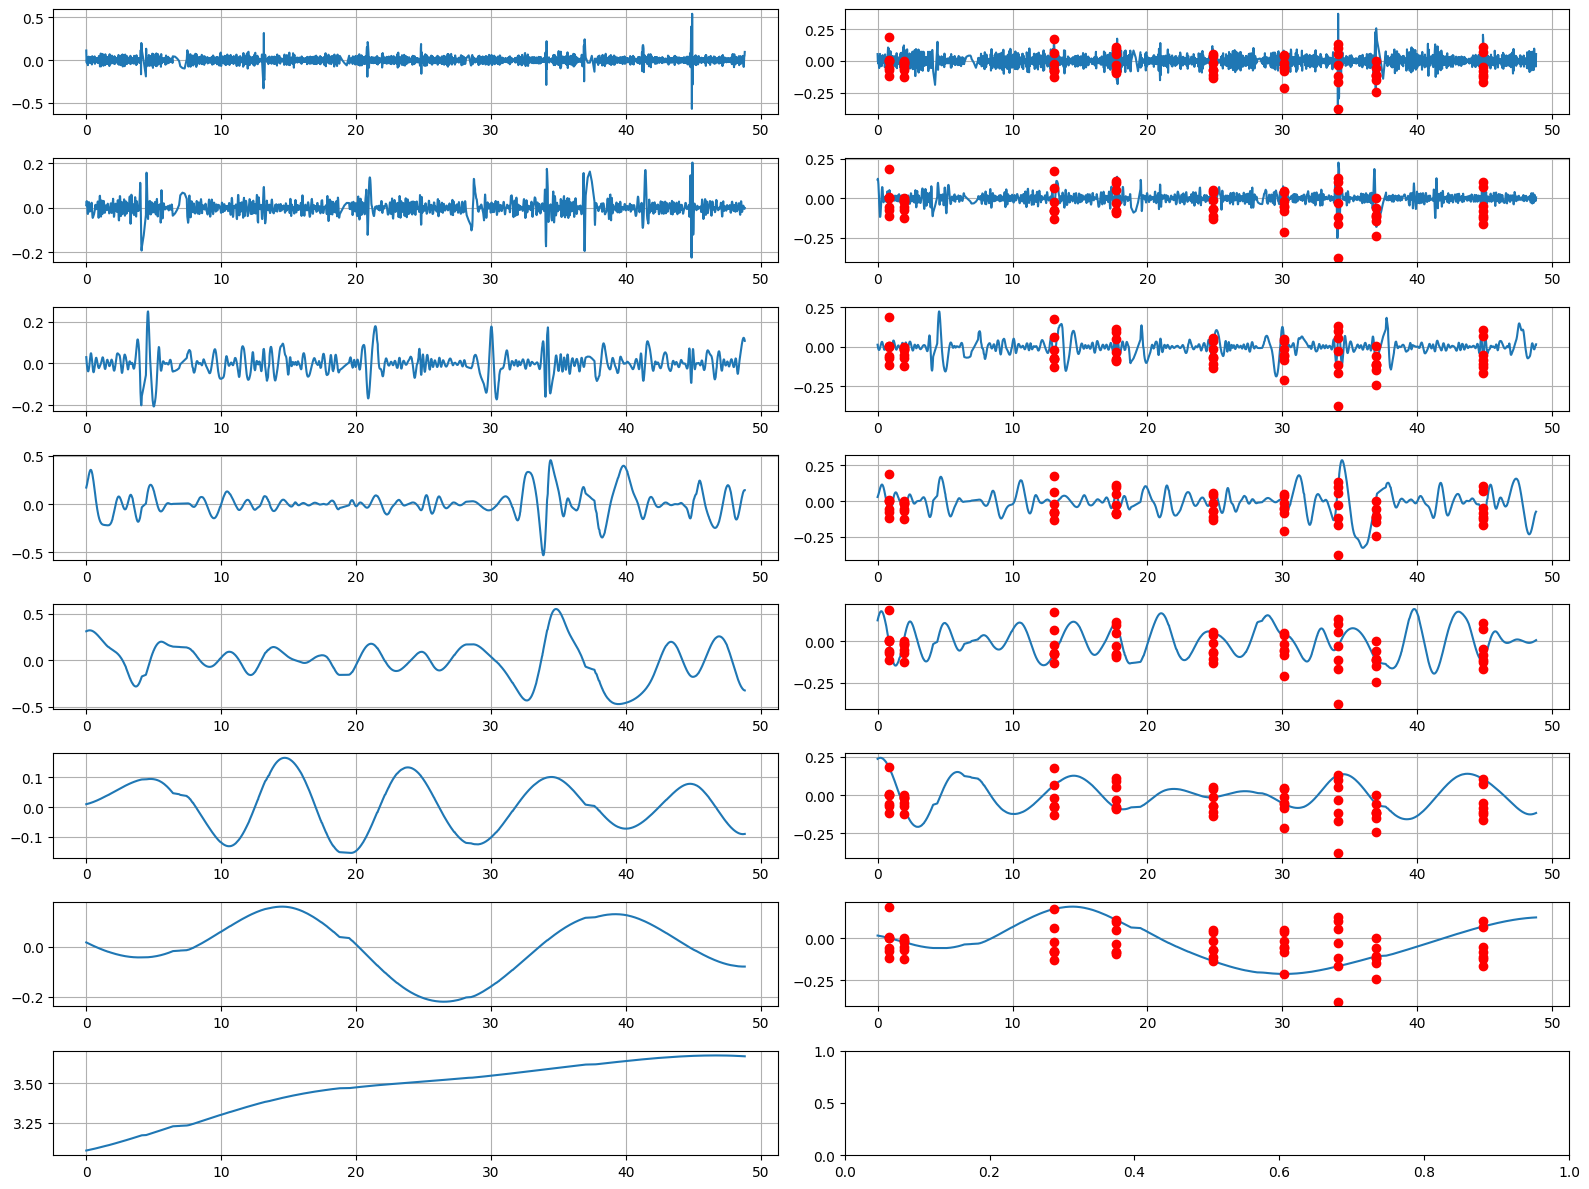

In [48]:
import emd
imf_l = emd.sift.sift(left)
imf_r = emd.sift.sift(right)
fig, ax = plt.subplots(max(imf_l.shape[-1], imf_r.shape[-1]), 2, figsize=(16, 12))
for i in range(imf_l.shape[-1]):
    ax[i, 0].plot(t_ax, imf_l[:, i])
    # ax[i, 0].plot(t_ax[blinks_l], imf_l[blinks_l], 'ro')
    ax[i, 0].grid(True)

for i in range(imf_r.shape[-1]):
    ax[i, 1].plot(t_ax, imf_r[:, i])
    ax[i, 1].plot(t_ax[blinks_r], imf_r[blinks_r, i], 'ro')
    ax[i, 1].grid(True)
plt.tight_layout()
plt.show()

51.0


(1.0, 25.0)

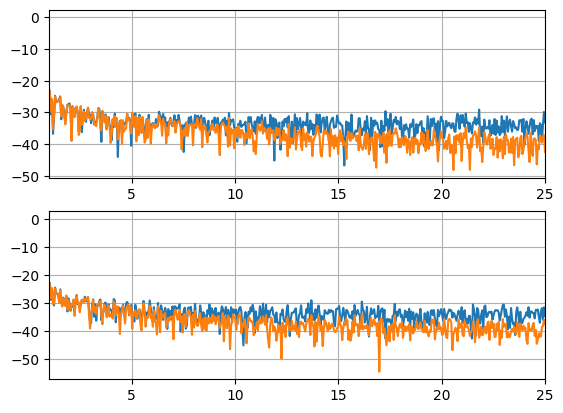

In [16]:
n_fft = 1024
L = np.fft.rfft(left, n=n_fft)
L_est = np.fft.rfft(left_est, n=n_fft)
R = np.fft.rfft(right, n=n_fft)
R_est = np.fft.rfft(right_est, n=n_fft)
# n_fft = left.shape[-1]
fs = float(np.ceil(1/np.median(np.diff(t_ax))))
print("{}".format(fs))
f_ax = np.arange(0, fs/2, fs/n_fft)
if f_ax.shape[-1] != R.shape[-1]:
    f_ax = np.arange(0, fs/2+fs/n_fft, fs/n_fft)
fig, ax = plt.subplots(2)
ax[0].plot(f_ax, 10*np.log10(np.abs(L)/np.max(np.abs(L))))
ax[0].plot(f_ax, 10*np.log10(np.abs(L_est)/np.max(np.abs(L_est))))
ax[0].grid(True)
ax[0].set_xlim(1, 25)

ax[1].plot(f_ax, 10*np.log10(np.abs(R)/np.max(np.abs(R))))
ax[1].plot(f_ax, 10*np.log10(np.abs(R_est)/np.max(np.abs(R_est))))
ax[1].grid(True)
ax[1].set_xlim(1, 25)

# Rendering of Eyes for Eye-Shape Registration and Gaze Estimation
https://www.cl.cam.ac.uk/research/rainbow/projects/syntheseyes/
syntheseyes_data

## The associated data for each image is a dict with keys:
    look_vec – the 3D gaze direction in camera space.
    head_pose – a 3x3 matrix rotation from world space to camera space.
    ldmks – a dict containing the following 2D and 3D landmarks:
    ldmks_lids_2d, ldmks_iris_2d, ldmks_pupil_2d in screen space.
    ldmks_lids_3d, ldmks_iris_3d, ldmks_pupil_3d in camera space

In [ ]:
import glob
import numpy as np
import pickle
from PIL import Image
import cv2
import matplotlib.pyplot as plt
data_path = r"../../datasets/eyetracking/syntheseyes_data"
fnames = sorted(glob.glob(data_path + "/**/**/*.pkl"))
with open(fnames[0], "rb") as f:
    data = pickle.load(f)
img = cv2.imread(fnames[0][:-4] + ".png")[:, :, ::-1]
lmks = np.array(data['ldmks']['ldmks_pupil_2d'])
plt.imshow(img)
plt.plot(lmks[:, 0], lmks[:, 1], 'o')
plt.plot(lmks[:, 0].mean(), lmks[:, 1].mean(), 'r.')
plt.show()

In [ ]:
x = np.load('../../datasets/eyetracking/dataset-eyetracking/dataset_example/eye_dataset.npz')
fig, ax = plt.subplots(2)
ax[0].imshow(x['arr_0'][2]/255)
ax[1].imshow(x['arr_1'][2]/255)